# Exploratory Data Analysis

This notebook is supposed to give the reader a clear overview on the data set at hand that is used to build a classifier that predicts the return probability of purchased goods in an E-commerce setting. The insights generated from this data exploration are then used to come up with ideas and recommendations for data cleaning and feature engineering that form the next steps in the overall workflow. 
<br>
<br>
The rest of the notebook is structured as follows:
1. __A first glimpse on the data__
2. __Taking a closer look at the numeric variables__
3. __Hidden information in the date-columns__ 
4. __Characteristics of categoricals__
5. __Summary of insights__

## 1. A first glimpse on the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import datetime
import re
import plot_fcts as pf
from utils import * 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

data_path = 'C:/Users/fstork/Documents/BADS2/data/'

known = pd.read_csv(data_path + 'BADS_WS1819_known.csv')
unknown = pd.read_csv(data_path + 'BADS_WS1819_unknown.csv')

In [2]:
data = pd.concat([known,unknown],axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_item_id  150000 non-null  object 
 1   order_date     150000 non-null  object 
 2   delivery_date  137655 non-null  object 
 3   item_id        150000 non-null  int64  
 4   item_size      150000 non-null  object 
 5   item_color     150000 non-null  object 
 6   brand_id       150000 non-null  int64  
 7   item_price     150000 non-null  float64
 8   user_id        150000 non-null  int64  
 9   user_title     150000 non-null  object 
 10  user_dob       134858 non-null  object 
 11  user_state     150000 non-null  object 
 12  user_reg_date  150000 non-null  object 
 13  return         100000 non-null  float64
dtypes: float64(2), int64(3), object(9)
memory usage: 17.2+ MB


Excluding the target variable (__'return'__), the data set contains $4$ __numeric__ variables (__'item_id', 'brand_id', 'user_id' and 'item_price'__) and $8$ variables of the type __object__. The names of these $8$ variables reveal that __four__ of them are actually __dates__ (__'order_date', 'delivery_date', 'user_dob', 'user_reg_date'__) and $3$ of them are categorical variables (__'item_size', 'item_color', 'user_state'__). The remaining variable is just the index column that allows for a clear identification of each data point.
<br>
<br>
Missing values don't seem to be a big problem in this data set, since only $3$ columns contain some of them. One of these three columns is the __target variable__ for which we are lacking 50,000 values. These do all stem from the test set for which we want to actually predict their realisations. The other __two__ variables with missing values are the date columns __"delivery_date"__ and __"user_dob"__ that will be investigated further in __section 3__.    

In [3]:
data.describe()

,item_id,brand_id,item_price,user_id,return
count,150000.000000,150000.000000,150000.000000,150000.000000,100000.000000
mean,2334.110367,96.511973,70.343994,33402.693713,0.481740
std,1742.174804,55.980588,45.316904,23987.377023,0.499669
min,1.000000,1.000000,0.000000,6.000000,0.000000
25%,528.000000,43.000000,34.900000,12912.000000,0.000000
50%,2378.000000,105.000000,59.900000,28442.000000,0.000000
75%,3518.000000,136.000000,89.900000,51203.500000,1.000000
max,6144.000000,266.000000,999.000000,86609.000000,1.000000


A quick check of the numeric variables of the data set shows that item prices seem to have strong outliers since the __maximum value__ is more than __10 times higher__ than the value of the __third quartile__. Moreover one can deduce from the mean value of the target variable (__'return'__), that we are dealing with a relatively __well balanced learning task__ since the average return rate is at almost __50%__. 

## 2. Taking a closer look at the (quasi) numeric variables

As already mentioned above, the data set consists of $4$ numeric variables plus the target variable. However, from the column names it is quite evident that only one of these four variables actually qualifies as a "true" numeric variable (__"item_price"__). The other three are rather to be classified as __categoricals__ and should therefore be dealt with in __section 4__. 
<br>
<br>
Nevertheless, there still one thing that could be investigated here for these three variables, which is if their characteristics vary across __train__ and __test__ set or if they are similar. For that I will specifically check if purchase events are equally distributed across the respective IDs for both the __train__ and the __test__ set. 

### 2.1 Item Prices

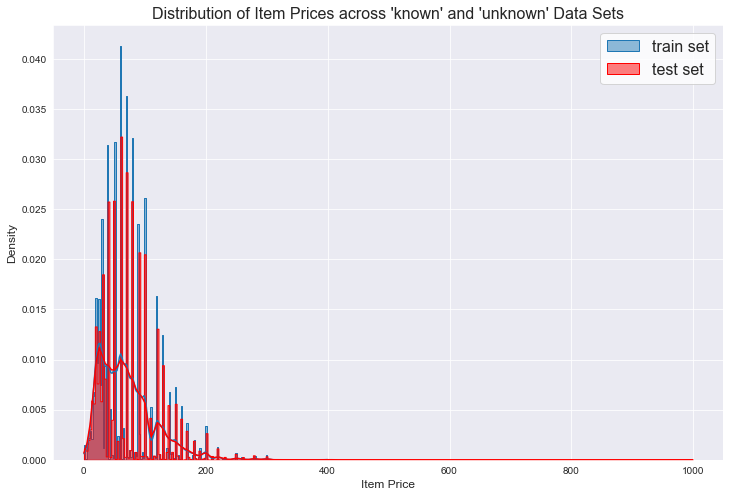

In [6]:
pf.hist_plot_comparison(train=known,test=unknown, var='item_price', var_label_title='Item Prices',fsize=(12,8))

Item prices seem to be equally distributed across both __train__ and __test__ data sets. Therefore, no particular cleaning steps are necessary except for some outlier removal.
<br> 
<br> 
Still, it might be interesting to visualize the item price development over time to identify seasonal or trend  patterns that also might influence the return rate in a certain form. A good example for such kind of pattern or event are sales promotions that usually result in higher demand, expressed by a rise in purchases and a drop in average item prices. 

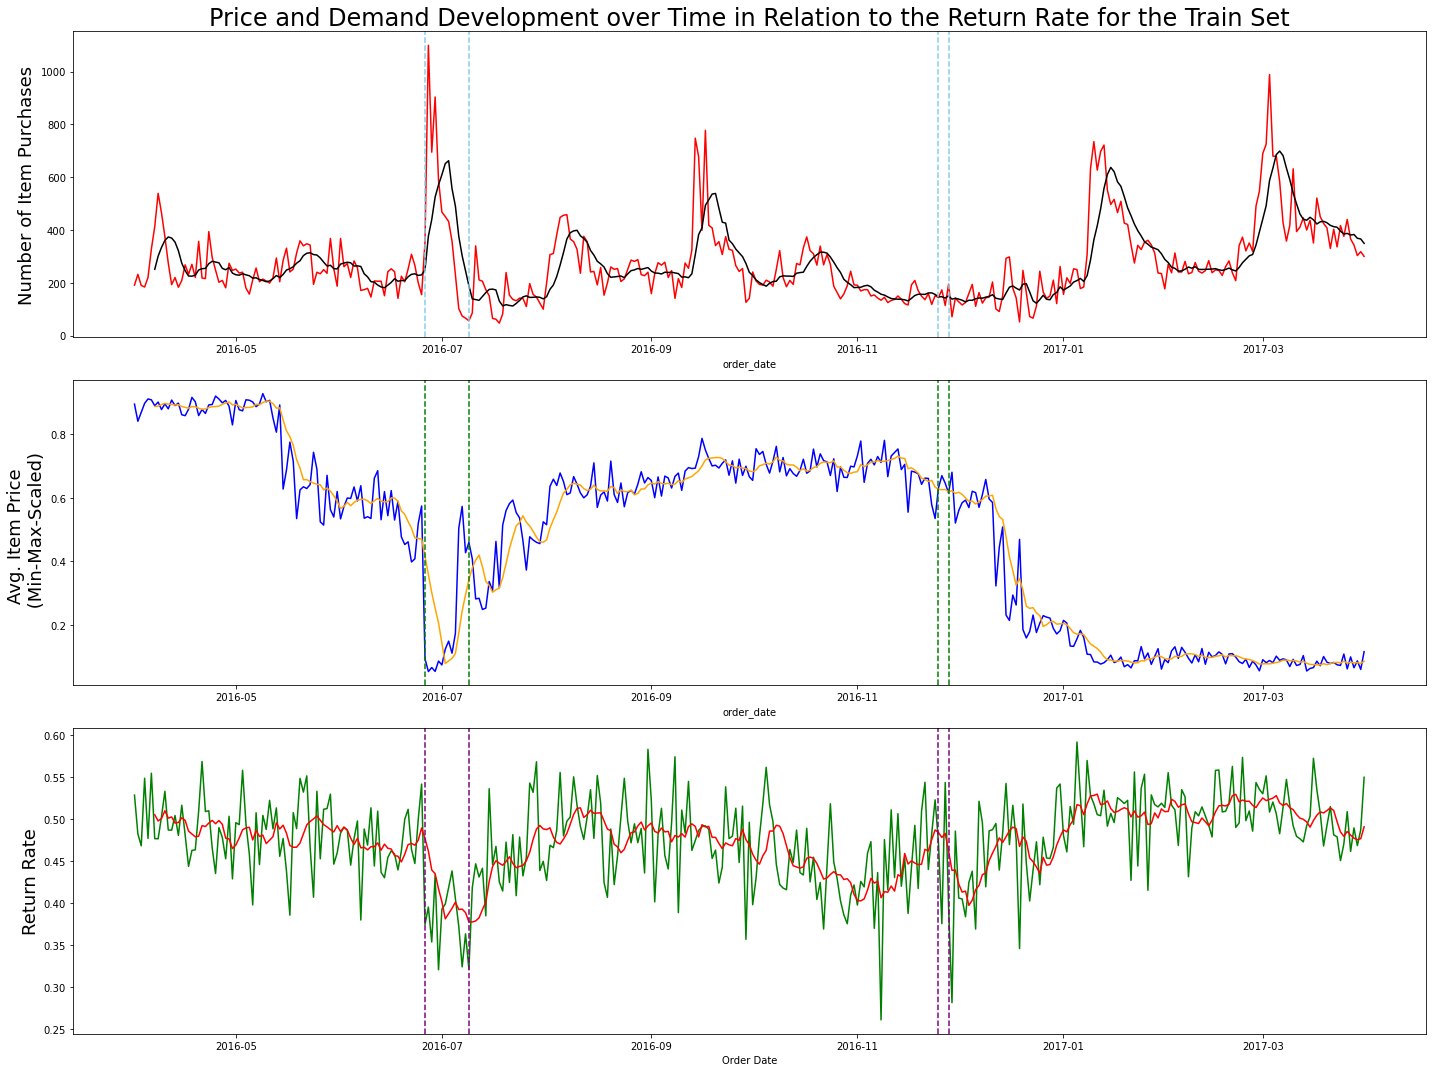

In [32]:
# Development over time: Train set (known)
pf.time_series_plot(data=known)

Looking at the __first__ of the three plots above, one can identify serveral sales promotion periods that materialize in spikes of the number of purchases per day. The one that is most pronounced takes place at the end of June 2016 and spills over to the first days of July 2016 too. It is accompanied by a drastic drop in average item prices (plot in the middle) and also by a drop in return rates (plot at the bottom).
<br>
<br>
After this sales promotion, average item prices quickly recover to their previous level and stay there until the end of the Christmas season after which they plunge again to the price level of the sales action in June/July. They remain at this level for the rest of the examination period. Dealing with an E-commerce business that operates in the fashion industry, this pattern in their price data isn't surprising since fashion products usually have a short lifetime of one or a few more seasons. Therefore, it is important to make room for new products of the upcoming season by selling old products for dumping prices. This is exactly what we can observe here. 
<br>
<br>
Additionally, it is quite interesting to see that there are a couple of spikes in the purchases per day, hinting at further sales actions that however do not seem to be triggered by item price reductions since the average item prices remain roughly the same. Return rates don't seem to be influenced by other sales promotions either, hence we should focus on the fist sales promotion in June/July when trying to construct a feature that is based on the occurance of sales promotions.
<br>
<br>
Before doing that, let's also check the test set (unknown) to check if the same pattern occurs here as well (at least for purchases per day and average item prices:

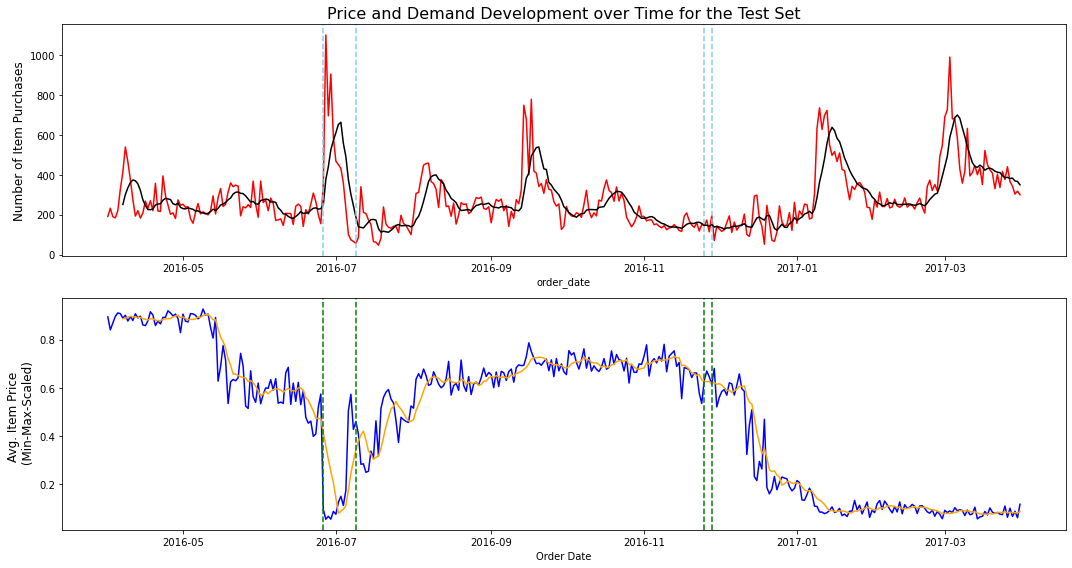

In [33]:
# Development over time: Train set (unknown)
pf.time_series_plot(data=unknown, fsize = (15,8))

The above plots (visualizing data from the test set) display more or less the same patterns wrt. to the number of daily purchases and the average item prices that were also seen in the train set (known). This is a good indication that return rates will most likely behave similarly too, rendering the sales promotion event in June/July as a potential candidate for a valuable feature.

### 2.2. Brand ID

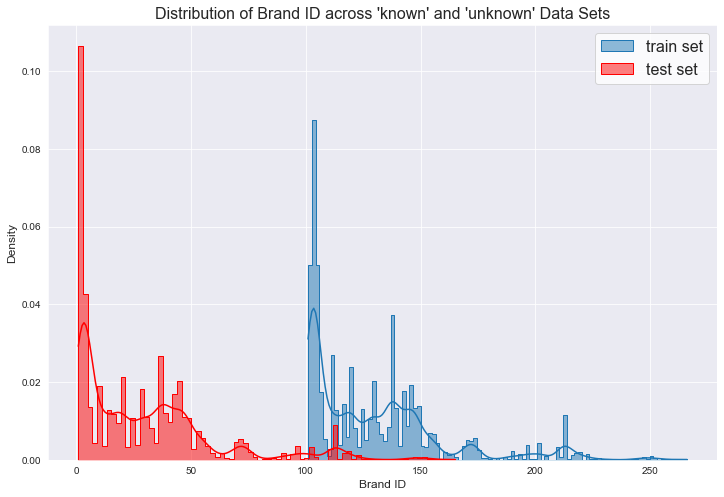

In [9]:
pf.hist_plot_comparison(train=known,test=unknown, var='brand_id', var_label_title='Brand ID',fsize=(12,8))

From the plot above one can clearly see that the brand IDs are shifted to the __right__: While in the test set ("unknown" - in red) the IDs start at __1__ and end at __165__; in the train set ("known" - in blue) they start at __101__ and end at __266__. Proceeding without adressing this issue would lead to a model that learns "wrong" characteristics from a potential brand ID feature that are not reflected by the test data. This will ultimately result in a worse performance, especially if a brand ID related feature turns out to be valuable during the model's learning process. 
<br>
<br>
To solve this problem, one can just __add 100__ to the brand IDs of the test set ("unknown") or one can __substract 100__ from the brand IDs of the train set ("known"). In this case, I decided to substract 100 from the train set's brand IDs:

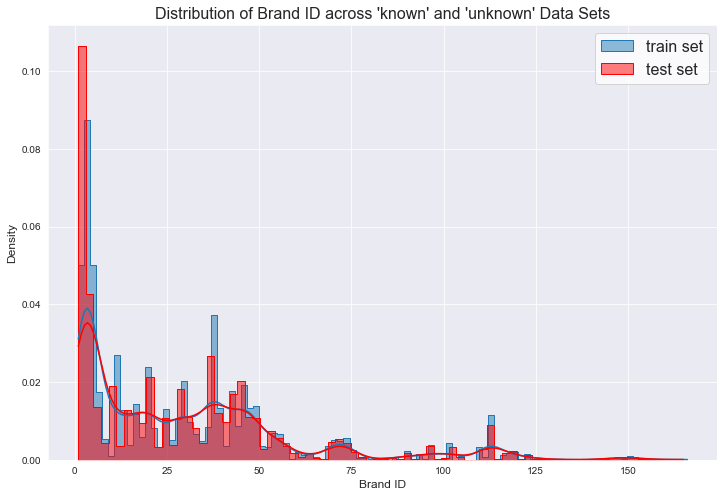

In [10]:
known['brand_id'] = known['brand_id'] - 100

pf.hist_plot_comparison(train=known,test=unknown, var='brand_id', var_label_title='Brand ID')

In order to further verify that this cleaning step had the desired effect and brand IDs of both data sets can 
now be accurately linked, I will check the __relative frequencies__, __mean prices__ and __variation in prices__ of brand IDs in both data sets. 

In [2]:
# Custom aggregation functions to check relative frequencies in a pandas.groupby statement
def rel_count_known(series):
    return series.shape[0] / 100_000
    
def rel_count_unknown(series):
    return series.shape[0] / 50_000

In [94]:
# Train set ("known"):
known.groupby('brand_id').agg({
    'item_price':[rel_count_known,'mean','std']
}).reset_index().head(5)

brand_id      item_price                       
           rel_count_known        mean        std
0        1         0.07499  118.273052  40.767521
1        2         0.00682   38.136070  10.681684
2        3         0.13370   30.840393  13.206790
3        4         0.00889   91.076434  32.238103
4        5         0.08176   64.303364  19.693767

In [97]:
# Test set ("unknown"):
unknown.groupby('brand_id').agg({
    'item_price':[rel_count_unknown,'mean','std']
}).reset_index().head(5)

brand_id        item_price                       
           rel_count_unknown        mean        std
0        1           0.07558  119.345713  41.649119
1        2           0.00718   38.145125  10.285645
2        3           0.13560   31.008850  13.384023
3        4           0.00832   91.255649  31.815784
4        5           0.07884   63.667882  19.839027

From the results above one can clearly see that for the __first 5 brand IDs__, not only do their acutal values now match, but also their __relative purchase frequencies__, their __mean item prices__ and the __variation in prices__ seem to be almost identical, hereby verifying that there is no structural difference between __brands__ in the __train__ and __test set__ anymore.

### 2.3. Item ID

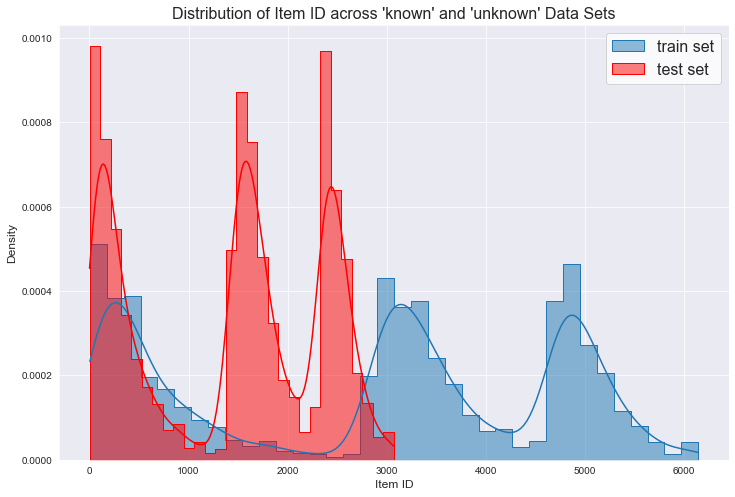

In [11]:
pf.hist_plot_comparison(train=known,test=unknown, var='item_id', var_label_title='Item ID')

For __item IDs__ one can see again a structural divergence between train __("known")__ and test set __("unknown")__: In particular, the IDs of the the train set seem to be shifted to the right again (as they were for the brand IDs too). However, this time they seem to be shifted by the constant factor __2__. 
<br>
<br>
I will adress that by dividing the IDs of the __train set__ by the factor 2, in order to make item IDs equal across both data sets. 

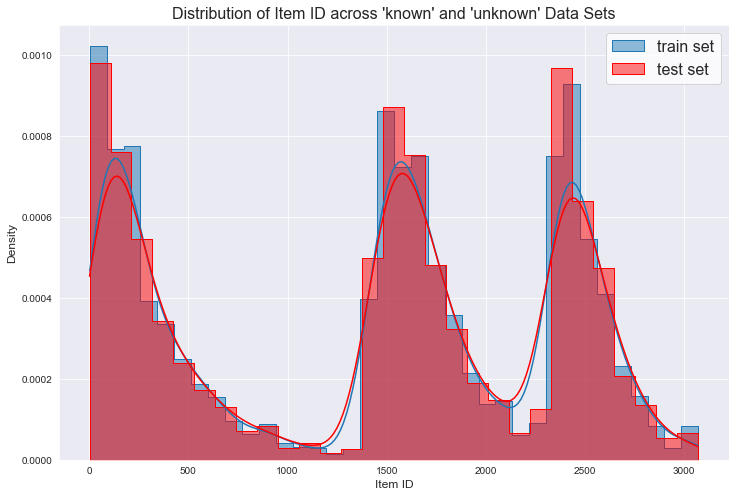

In [3]:
known['item_id'] = known['item_id'].apply(lambda x: int(x / 2))

pf.hist_plot_comparison(train=known,test=unknown, var='item_id', var_label_title='Item ID')

Similar to the approach for correcting the brand IDs, I will also verify if the above correction had the desired effect of making the item IDs of both data sets match. This will again be verified by checking the __relative purchase frequencies__, __mean item prices__ and the __variation in item prices__ of item IDs across the train and the test set. 

In [4]:
# Train set ("known"):
tmp_known = known.groupby('item_id').agg({
    'item_price':[rel_count_known,'mean','std']
}).reset_index().head(5)
tmp_known

item_id      item_price                       
          rel_count_known        mean        std
0       2         0.00163  108.979755  20.361238
1       3         0.00078   30.925641   9.200472
2       4         0.00113   23.262832   7.513157
3       5         0.00064   90.056250  21.984279
4       6         0.00157   51.938217  15.358488

In [5]:
# Test set ("unknown"):
tmp_unknown = unknown.groupby('item_id').agg({
    'item_price':[rel_count_unknown,'mean','std']
}).reset_index().head(5)
tmp_unknown

item_id        item_price                       
          rel_count_unknown        mean        std
0       1           0.00180  112.788889  17.752635
1       2           0.00074   29.494595   9.382192
2       3           0.00108   23.233333   7.523548
3       4           0.00068   90.782353  20.355574
4       5           0.00192   54.275000  15.479188

From the tables above one can clearly see that relative purchase frequencies, mean item prices and the variation in item prices seem to be more or less equal across the first five examples of item IDs in both data sets. 
<br>
<br>
However, with respect to the __"item_id"-column__ itself, one can observe that it starts at __2__ for the train set and at __1__ for the test set. This can indicate that there is still some degree of mismatch of item IDs across both train and test set.

In [22]:
# Top 3 most frequent customer IDs of 'known'-dataset
tmp_known.columns = ['item_id','rel_count','item_price_mean','item_price_std']
tmp_unknown.columns = ['item_id','rel_count','item_price_mean','item_price_std']
tmp_known['type'] = 'train'
tmp_unknown['type'] = 'test'

tmp = pd.concat([tmp_known,tmp_unknown],axis=0).reset_index(drop=True)
tmp

,item_id,rel_count,item_price_mean,item_price_std,type
0,1,0.00163,108.979755,20.361238,train
1,2,0.00078,30.925641,9.200472,train
2,3,0.00113,23.262832,7.513157,train
3,4,0.00064,90.056250,21.984279,train
4,5,0.00157,51.938217,15.358488,train
5,1,0.00180,112.788889,17.752635,test
6,2,0.00074,29.494595,9.382192,test
7,3,0.00108,23.233333,7.523548,test
8,4,0.00068,90.782353,20.355574,test
9,5,0.00192,54.275000,15.479188,test


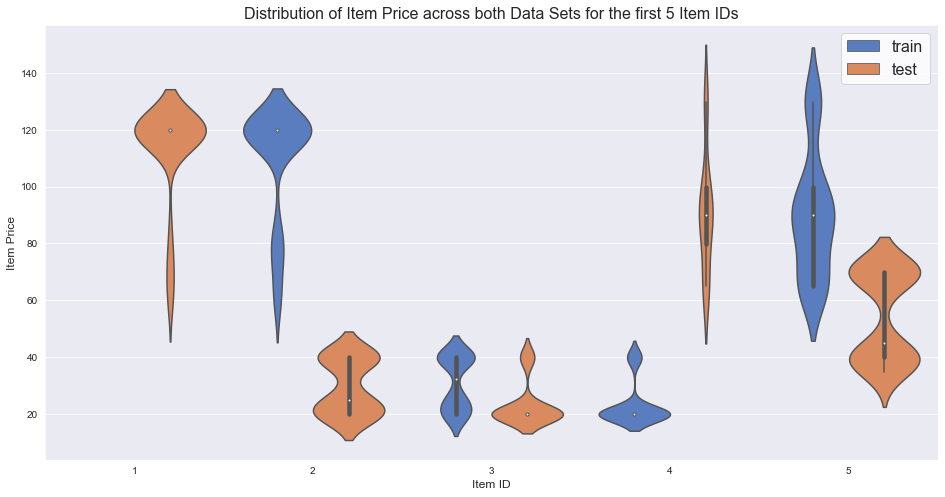

In [16]:
arg_dict = {
    'train': known
    , 'test': unknown
    , 'dimx': 'item_id'
    , 'dimy': 'item_price'
    , 'dimx_label': 'Item ID'
    , 'dimy_label': 'Item Price'
    , 'fsize': (16,8)
}

pf.violin_plot_comparison(**arg_dict)

From the violin plots above it is evident that item IDs still appear to be shifted by __1__: For instance, the distribution of prices of __item ID 2__ in the __test set__ (orange) seems to be identical to the distribution of prices of __item ID 3__ in the __train set__ as opposed to the distribution of prices of __item ID 2__ in the train set.
<br>
<br>
The same logic applies to all the other item IDs depicted above except for __item ID 1__ which doesn't have a counterpart in the train set with the same item ID. However, the distribution of item prices strongly resembles the distribution of prices of item ID 2 in the train set. 
<br>
<br>
Consequently, one must admit that dividing item IDs of the train set by the factor __2__ didn't completely resolve the mismatch issue of item IDs across the two data sets. Additionally one has to substract __1__ unit from the item IDs in the train set to finally be able to link item IDs of both data sets in the correct way as one can see in the plot below:

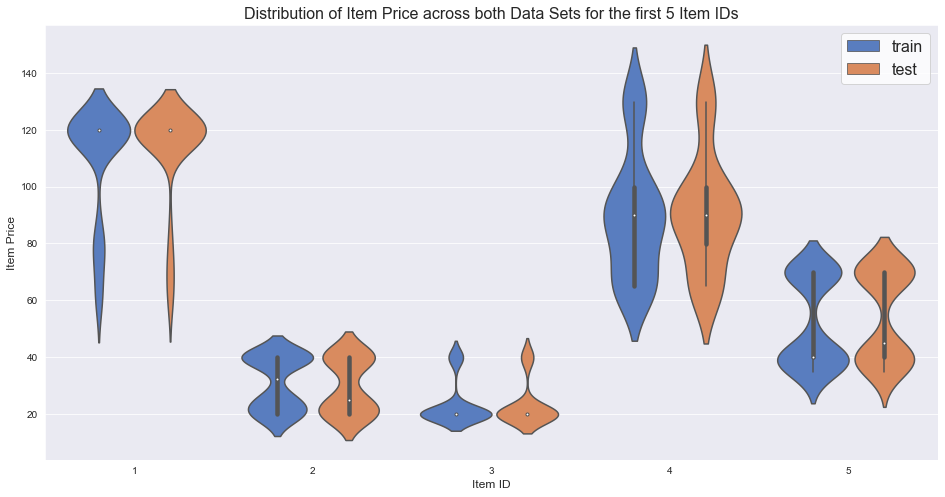

In [17]:
known['item_id'] = known['item_id'] - 1

arg_dict = {
    'train': known
    , 'test': unknown
    , 'dimx': 'item_id'
    , 'dimy': 'item_price'
    , 'dimx_label': 'Item ID'
    , 'dimy_label': 'Item Price'
    , 'fsize': (16,8)
}

violin_plot_comparison(**arg_dict)

### 2.4. User ID 

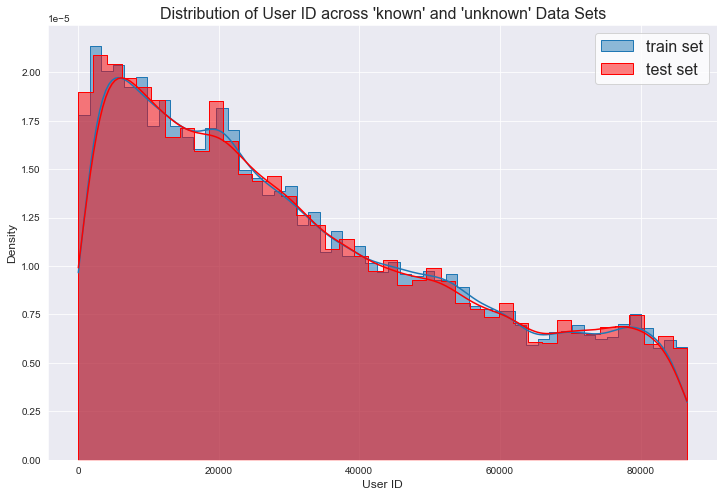

In [2]:
pf.hist_plot_comparison(train=known,test=unknown, var='user_id', var_label_title='User ID')

Both training ("known") and test ("unknown") data sets seem to have an almost perfect overlap. This strongly suggests that no particular cleaning seems to be necessary for this variable. Still, I also checked the top 3 most frequent customer IDs of both data sets to verify that they match and that their mean item prices & standard deviations look similar.

In [65]:
# Top 3 most frequent customer IDs of 'known'-dataset
tmp_known = known.groupby('user_id').agg({
    'item_price': ['count','mean','std']
}).reset_index()
tmp_known.columns = pd.Series(tmp_known.columns.tolist()).apply(lambda x: '_'.join(x))
tmp_known.sort_values(by='item_price_count',ascending=False).head(3).reset_index(drop=True)

,user_id_,item_price_count,item_price_mean,item_price_std
0,2649,81,69.388395,42.446930
1,744,75,46.901333,26.673361
2,27390,67,53.919403,24.471876


In [66]:
# Top 3 most frequent customer IDs of 'unknown'-dataset
tmp_unknown = unknown.groupby('user_id').agg({
    'item_price': ['count','mean','std']
}).reset_index()
tmp_unknown.columns = pd.Series(tmp_unknown.columns.tolist()).apply(lambda x: '_'.join(x))
tmp_unknown.sort_values(by='item_price_count',ascending=False).head(3).reset_index(drop=True)

,user_id_,item_price_count,item_price_mean,item_price_std
0,2649,44,84.038864,47.387423
1,744,38,46.830263,24.552287
2,27390,34,57.017647,21.171400


All in all the evidence shown above clearly indicates that the characteristics of user IDs in the __"known"__ & the __"unknown"__ data set seem to match each other, rendering further cleaning steps unnecessary.
<br>
<br>
However, as one can see below, there are still a lot of user IDs, that are __exclusive to one of the two data sets__ which is something that needs to be adressed later on during feature engineering.

In [73]:
a = len(np.setdiff1d(known['user_id'], unknown['user_id'])) / len(np.unique(known['user_id']))
print(f"The share of unique user IDs in 'known' that are not in 'unknown': {a*100:.2f}%")

The share of unique user IDs in 'known' that are not in 'unknown': 47.48%


In [75]:
b = len(np.setdiff1d(unknown['user_id'], known['user_id'])) / len(np.unique(unknown['user_id']))
print(f"The share of unique user IDs in 'unknown' that are not in 'known': {b*100:.2f}%")

The share of unique user IDs in 'unknown' that are not in 'known': 25.54%


<br>
<br>

## 3. Hidden information in the date-columns

### 3.1. The Delivery Duration

The first two date columns in both data sets are __"order_date"__ and __"delivery_date"__ which describe the day on which a customer placed an order and on which he/she received that order. It might be interesting to investigate the time that passed between order placement and receival of the item, since items that were received relatively late, could display a higher propensity to be returned than items that were received realtively early. The intuition behind this is that if a customer orders two similar items and one of them arrives earlier than the other, the customer could already make his/her choice to buy the first item and thus return the second one. 
<br>
<br>
Let's investigate that theory further by looking at the acutal data:

In [3]:
known['delivery_duration'] = (pd.to_datetime(known['delivery_date']) - pd.to_datetime(known['order_date'])).dt.days

known['delivery_duration'].describe().reset_index().rename(columns={'index': 'Stats', 0: 'Values'})

,Stats,delivery_duration
0,count,91708.000000
1,mean,-72.781502
2,std,812.549451
3,min,-8126.000000
4,25%,2.000000
5,50%,3.000000
6,75%,8.000000
7,max,151.000000


The above statistics on the delivery duration reveal that the majority of items is delivered within roughly one week. However, one can also observe that there are some data points with a negative value which doesn't make sense since an item can't be delivered to someone before this person places an order. Therefore it is most likely that these data points represent cases in which a default value was set because a technical error occured or the got lost somehow.

In [37]:
known.groupby('delivery_date').agg({
    'order_item_id': 'count'
    , 'return': 'mean'
}).rename(columns={
    'order_item_id': 'counts'
    , 'return': 'return_rate'
}).sort_values(by='counts',ascending=False).reset_index().head()

,delivery_date,counts,return_rate
0,2017-04-04,1129,0.567759
1,2016-07-03,1050,0.496190
2,2017-01-14,966,0.524845
3,1994-12-31,959,0.329510
4,2017-01-01,937,0.526147


The table above confirms this theory since out the top 5 most frequent delivery dates, we get __'1994-12-31'__ on place number 4 which is obviously some kind of default value. To prevent it from distorting the __"delivery_duration"__ feature, I will replace all negative values with the __median__ delivery duration. 
<br>
<br>
However, as one can see from the __return_rate__ column, data points with this default value have a stronger propensity to keep the item than others. Hence, setting them to the median value will result in a loss of information. To circumvent this, I will introduce a dummy variable that is set to __1__ if the __delivery_duration__ is negative and __0__ otherwise.  

Aside from negative values, the delivery duration has another interesting trait: It consists of a lot of missing values:

In [24]:
known['delivery_duration'] = known['delivery_duration'].apply(str)

known.groupby('delivery_duration').agg({
    'order_item_id': 'count'
    , 'return': 'mean'
}).rename(columns={
    'order_item_id': 'value_counts'
    , 'return': 'return_rate'
}).sort_values(by='value_counts', ascending=False).head(5).reset_index()

,delivery_duration,value_counts,return_rate
0,2.0,17402,0.534077
1,3.0,16809,0.545363
2,1.0,13919,0.503053
3,4.0,10841,0.551702
4,nan,8292,0.000000


More importantly, the data points with missing delivery date are __exclusively labeled with "no return"__ which would make a dummy variable that reflects on this a very, very potent predictor. The background for this is most likely of processual nature: Orders can be canceled before delivery e.g. because the customer accidently put the wrong item into basket and placed an order before noticing that. Usually E-commerce business allow for cancelling items in the order in such cases which probably what happened here as well.

### 3.2. The Customer Age

Another interesting aspect that could be derived from date-columns is the __customer age__ in years during the order process. However, from __section 1__ we already know that the __'user_dob'-column__ has a significant amount of __missing values__ which will require some form of __imputation__:

In [13]:
known['age'] = (pd.to_datetime(known['order_date']) - pd.to_datetime(known['user_dob'])).dt.days / 365
unknown['age'] = (pd.to_datetime(unknown['order_date']) - pd.to_datetime(unknown['user_dob'])).dt.days / 365
print(f"Train Set - Number of missing values in 'age': {known['age'].isnull().sum()}")
print(f"Test Set - Number of missing values in 'age': {unknown['age'].isnull().sum()}")

Train Set - Number of missing values in 'age': 10023
Test Set - Number of missing values in 'age': 5119


In [9]:
known['age'].describe().reset_index()

,index,age
0,count,89977.000000
1,mean,52.572435
2,std,11.135461
3,min,4.112329
4,25%,46.430137
5,50%,51.824658
6,75%,57.473973
7,max,116.435616


In [10]:
unknown['age'].describe().reset_index()

,index,age
0,count,44881.000000
1,mean,52.565330
2,std,11.084476
3,min,4.457534
4,25%,46.372603
5,50%,51.827397
6,75%,57.498630
7,max,116.435616


The above tables imply that the __customer age__ is equally distributed across train and test set. They also show however that the __age__ variable suffers from outliers as there are data points with an age __far beyond 100 years__. Let's check how many data points have such a high age and if the corresponding birthdates look somehwhat suspicious. It could potentially be that that some kind of __default value__ causes these high ages or that customers used __fake birthdates__ because they didn't want to reveal their true age.

In [5]:
known.groupby(['user_dob']).agg({
    'order_item_id': 'count'
    , 'return': 'mean'
}).reset_index().sort_values(
    by='order_item_id',ascending=False
).reset_index(drop=True).head()

,user_dob,order_item_id,return
0,1900-11-21,858,0.522145
1,1949-11-21,487,0.453799
2,1962-01-02,88,0.409091
3,1964-03-13,82,0.487805
4,1979-02-07,81,0.185185


__'1900-11-21'__ and __'1949-11-21'__ seem to be default values as they appear much more frequently than any other birthdate. For these data points, I will replace the corresponding age by the __median age__.
<br>
<br> 
However, let's also take a look at the age distribution after cleaning the two default dates and the missing values by replacing them with the __"cleaned" median__:

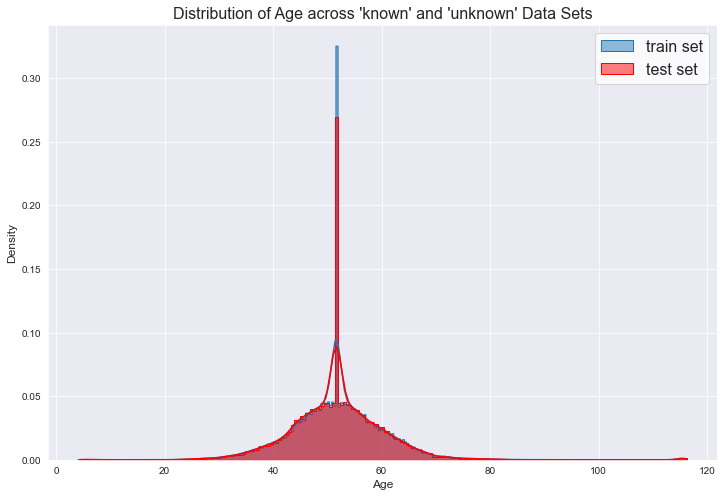

In [15]:
med = known.loc[~known['user_dob'].isin(['1900-11-21','1949-11-21']),'age'].median()

# Replace ages that were constructed on default values with the median
known.loc[known['user_dob'].isin(['1900-11-21','1949-11-21']),'age'] = med
unknown.loc[unknown['user_dob'].isin(['1900-11-21','1949-11-21']),'age'] = med

# Replace missing values with median
known['age'].fillna(med, inplace=True)
unknown['age'].fillna(med, inplace=True)

# Plot age distribution
pf.hist_plot_comparison(train=known,test=unknown, var='age', var_label_title='Age')

The plot above again underlines that age is equally distributed across train and test set, so no additional cleaning steps are necessay between the two data sets. The great majority of customers has an age between 40 and 60 years, hence the products that are offered by this E-commerce business seem to target peole of the middle age. 

### 3.3. Customer Lifetime

Another aspect that could be interesting to investigate further is the customer lifetime. That is, the time passed between the user registration date and the respective order date. Let's first check some general characteristics of the distribution of customer lifetime in the train set:

In [9]:
known['clt'] = (pd.to_datetime(known['order_date']) - pd.to_datetime(known['user_reg_date'])).dt.days
known['clt'].describe().reset_index()

,index,clt
0,count,100000.000000
1,mean,286.895750
2,std,257.714016
3,min,-1.000000
4,25%,1.000000
5,50%,253.000000
6,75%,505.000000
7,max,773.000000


The __average lifetime__ is at roughly $287$ days with a relatively high __standard deviation__ of $257.71$ days. The __maximum customer lifetime__ in the train set is at $773$ days. The __minimum__ is at $-1$ days which makes no sense since the __customer lifetime__ cannot be below $0$. Let's check how many data points are affected by this phenomenon: 

In [10]:
print(f"Number of data points with customer lifetime below 0: {sum(known['clt'] < 0)}")

Number of data points with customer lifetime below 0: 24512


So, roughly one quarter of the data set is affected by this pattern, where the __user_reg_date__ is $1$ day after the __order_date__. For simplicity, let's set all data points with a __customer lifetime__ of $-1$ to $0$ by adding $1$ to the difference between __order_date__ and __user_reg_date__.
<br>
<br>
Let's also quickly check if the distributions of the __customer lifetime variable__ are similar across train and test set: 

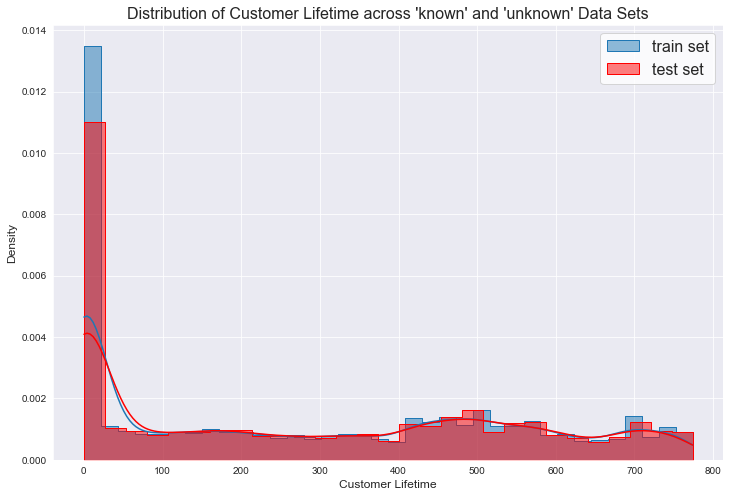

In [12]:
known['clt'] = (pd.to_datetime(known['order_date']) - pd.to_datetime(known['user_reg_date'])).dt.days + 1
unknown['clt'] = (pd.to_datetime(unknown['order_date']) - pd.to_datetime(unknown['user_reg_date'])).dt.days + 1

pf.hist_plot_comparison(train=known,test=unknown, var='clt', var_label_title='Customer Lifetime')

<br>
<br>

## 4. Characteristics of categoricals

So far we only had a look at metric or date variables, however, there is another variable type that is acutally the predominant type in the original data set: __categorical variables__. 
<br>
<br>
All in all we have 7 categorical variables in the data set, which all are listed below:

- user_id
- user_title
- user_state
- item_id
- item_size
- item_color
- brand_id

Let's have a look at the number of unique values in each variable:

In [64]:
cat_cols = ['user_id','user_title','user_state','item_id','item_size','item_color','brand_id']
df = pd.DataFrame({'cat_col_name': cat_cols, 'num_unique_vals':[len(known[col].unique()) for col in cat_cols]})
df.sort_values(by='num_unique_vals',ascending=False).reset_index(drop=True)

,cat_col_name,num_unique_vals
0,user_id,37663
1,item_id,2656
2,brand_id,155
3,item_size,114
4,item_color,85
5,user_state,16
6,user_title,5


As we can see, the number of unique variables (here: train set only) is too high for all variables but __user_state__ and __user_title__ to just convert them into dummy variables. Therefore it is necessary to somehow convert the categories in these variables into a numeric representation without losing the relationship to the target. One such transformation is the __weight of evidence transformation (WoE)__ which is very popular for example in _credit scoring_. 
<br>
<br>
It establishes a monotonic relationship between independant and dependant variables by computing the log ratio between the number of all non-events $(n_{y=0})$ and events $(n_{y=1})$ in the category $c$, scaled by the ratio of all events $(N_{1})$ and non-events $(N_{0})$ in the sample. Or expressed differently, it examines how well one can distinguish between events and non-events using the corresponding category, and encodes this into a numeric representation. The further away the $WoE$ of a category $c$ is from $0$, the more informative is this category. 
Formally, this can be expressed as 
<br>
<br>
<br>
$$WoE_{c} = ln\left[\frac{n_{y=0,c}}{n_{y=1,c}}\cdot\frac{N_{1}}{N_{0}}\right] = ln\left[\frac{\text{percentage of non-events in c}}{\text{percentage of events in c}}\right]$$
<br>
<br>
$$\text{, where percentage of non-events in c} = \frac{n_{y=0,c}}{N_{0}}$$
<br>
$$\text{and percentage of events in c} = \frac{n_{y=1,c}}{N_{1}}$$
<br>

In order to be able to do feature selection with WoE-transformed variables, it is quite common to compute the corresponding __information value (IV)__ of this variable. It gives an indication as to how important this variable can be in a predictive model. Additionally it can help to identify WoE-transformed variables that are prone to amplify overfitting of the model. 
<br>
<br>
The information value of a category $c$ is computed by multiplying the $WoE$ of that category with the difference between the percentage of non-events and events in $c$. If you do this for every category $c$ in a variable $X$, you'll get the information value of the entire variable $X$.  

<br>
$$IV = \sum_{c=1}^{C} (\text{percentage of non-events in c} - \text{percentage of events in c}) \cdot WoE_{c}$$
<br>
$$or$$
<br>
$$IV = \sum_{c=1}^{C} ( \frac{n_{y=0,c}}{N_{0}} - \frac{n_{y=1,c}}{N_{1}}) \cdot WoE_{c}$$
<br>

Let's apply these concepts to the categorical variables in the data set (even to those two which will most likely be processed via dummification later on). After the __WoE-transformation__, the 7 categorical variables in the data set give the following information values: 

In [65]:
woe_col_list = ['item_id', 'item_size', 'item_color', 'brand_id', 'user_id', 'user_title', 'user_state']

iv_output = compute_iv(data=known,woe_vars=woe_col_list,correction=0.00001)
pd.DataFrame({
    'variable': [key for key in iv_output.keys()]
    , 'IV': [val for val in iv_output.values()]
}).sort_values(by='IV',ascending=False)

,variable,IV
4,user_id,1.467689
0,item_id,0.441149
3,brand_id,0.150604
1,item_size,0.065605
2,item_color,0.035237
5,user_title,0.003962
6,user_state,0.003255


In order to give some indication as to which magnitudes of __IV__ are good and which are bad, [Siddiqi (2006)](https://onlinelibrary.wiley.com/doi/book/10.1002/9781119201731) defined the following rules of thumb for the information value of a __WoE-transformed__ variable:
<br>
1. $IV < 0.02 \longrightarrow \text{not useful for prediction}$   
2. $0.02 \leq IV > 0.1 \longrightarrow \text{weak predictive power}$
3. $0.1 \leq IV > 0.3 \longrightarrow \text{medium predictive power}$
4. $0.3 \leq IV > 0.5 \longrightarrow \text{strong predictive power}$
5. $IV > 0.5 \longrightarrow \text{suspicious predictive power, i.e. strong risk of overfitting}$
<br>

So, in accordance with those rules of thumb, we can say that __user_title__ & __user_state__ seem to be almost useless for predicting item returns of a specific customer. However, since both variables are likely candidates for dummification anyway, they will remain in the training data set, to see if they can least marginally improve model performance. For __WoE-transformation__, those two won't be considered any further though. 
<br>
<br>
Next up in the ranking are __item_color__ and __item_size__, which both qualify for the __"weak predictive power"__ category as they have an __IV__ below $0.1$. With respect to "medium predictive power", the only variable that qualifies for this label is __brand_id__ with an __IV-score__ of $0.1506$. The only categorical variable that can be classified as a strong predictor though is __item_id__ with an __IV-score__ of $0.4411$. 
<br>
<br>
Still we are missing our highest ranking variable in terms of __IV__, which is __user_id__. In this case however, the 
__IV-score__ is too good to be true $(1.4676)$, which makes a lot of sense, since many of WoE values in __user_id__ are calculated for users that only have one data point to their "name" (or better "ID"). Hence, we have to preprocess the __user_id__ variable before transforming it into its __WoE-representation__. I decided to define a minimum amount of data points a __user_id__ must have in the training set to get an own __WoE-representation__ (i.e. a minimum frequency threshold). Every __user_id__ that would fall below that minimum amount would be "thrown" into a new category ("misc" - for miscellaneous) that captures a lot of the noise in the __user_id__ column.  To determine the cut-off value, I had a look at how the __IV-score__ would develop under varying __frequency thresholds__:  

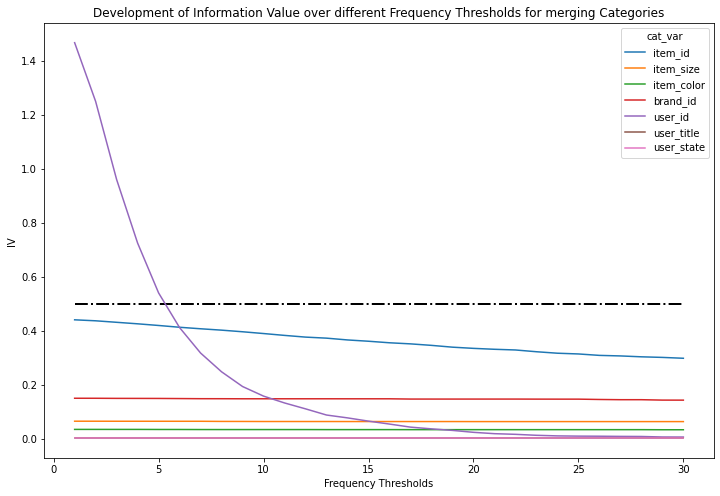

In [2]:
arg_dict = {
    'col_list': ['item_id', 'item_size', 'item_color', 'brand_id', 'user_id', 'user_title', 'user_state']
    , 'path': 'C:/Users/fstork/Documents/BADS2/data/'
    , 'xmax': 30
}

pf.freq_thr_plot(**arg_dict)

As one can see above, the __user_id__ is very sensitive to the frequency threshold: A value of 1 will result in the previously reported __IV-score__ of $1.4411$ while a threshold of $10$ will already result in an __IV-score__ similar to the score of the variable __brand_id__. Increasing it further to values over $20$ will alreay render it useless. 
<br>
Interestingly, the __IV-scores__ of the other variables are much less sensitive to variations in the frequency threshold which probably makes them much more stable and reliable predictors than the __user_id__-column. Still, it might be a bad idea to exclude the __user_id__ feature entirely from the modelling process, as the overlap between __user_ids__ in the __train set__ and __user_ids__ in the __test set__ is quite significant:

In [62]:
known = pd.read_csv(data_path + 'BADS_WS1819_known.csv')
rel_overlap = len(np.intersect1d(known['user_id'],unknown['user_id'])) / len(unknown['user_id'].unique())

print(f"The relative overlap of User IDs in train & test: {rel_overlap*100:.2f}%")

The relative overlap of User IDs in train & test: 74.46%


After all, one can consider the frequency threshold for the __user_id__-variable as an additional hyperparameter then, that needs to be tuned during model training. As an initial value however, one could pick a cut-off at $5$, as it would result in an __IV-score__ of just below $0.5$, which is the upper boundary for strong predictors as defined by [Siddiqi (2006)](https://onlinelibrary.wiley.com/doi/book/10.1002/9781119201731). 

<br>
<br>

## 5. Summary of Insights

In this section I will give a brief summary over the most interesting findings that were derived from the analysis in this notebook. 

1. __A first glimpse on the data__
    - the data sets have __14 variables__ and __150,000 data points__ in total (train + test set)
    - the set of variables consists of $1$ ID-column, $4$ date columns, $1$ numeric column, $7$ categorical variables and the target variable
<br>
<br>
<br>
2. __Taking a closer look at the (quasi) numeric variables__
    - the development of standardised item prices over time reveals that there must have been one major sales campaign throughout the year which boosted the amount of orders quite a lot and also reduced the average return rate in the train set quite significantly.
    - values of the __brand_id__ and __item_id__-columns in the train and the test set don't match which necessitated a manual correction
    - __user_ids__ match across train and test set for roughly 75% of all unique __user_ids__ which makes it reasonable to assume that no further cleaning steps are necessary for this variable
<br>
<br>
<br>
3. __Hidden information in the date-columns__
    - the delivery_date columns has plenty of missing values which all have a $0$ as realisation of the target variable, making it a very powerful predictor for the subsequent models
    - the delivery duration contains a lot of cases where the delivery duration is __negative__. These cases occur when a default value is set for the delivery date (31.12.1994). Since these cases have a strong propensity for returns, I will introduce a dummy variable that indicates if such a default value was set and replace negative values in the delivery duration feature with the median
    - the average customer age is at around 45 years
    - 25% of all customers in the train set seem to be __new customers__, as their customer life time is $0$
<br>
<br>
<br>
4. __Characteristics of categoricals__
    - as there are only two categorical variables in the data set that qualify for dummification (due to a relatively low number of unique categories), it is necessary to transform the other 5 categoricals (__user_id__, __item_id__, __item_color__, __item_size__, __brand_id__) in a numeric representation that is related to the target variable in a monotonic fashion
    - the solution to this is a __WoE-transformation (Weight of Evidence)__
    - quantifying the predictive power of the __WoE-transformation__ of those $5$ categoricals using the concept of information value __(IV)__ reveals that __item_color__ and __item_size__ are of low predictive power, __brand_id__ is of medium predictive power, __item_id__ is of high predictive power and __user_id__ is very prone to cause overfitting. The latter can however be controlled by bundling __user_ids__ with a low frequency in a new category called __"misc"__ (_for miscellaneous_) which captures a lot of the noise in the variable.